In [49]:
from torchsummary                 import summary
from tqdm                         import tqdm
from src.data.to_tensor           import ToTensor
from src.data.mrw_dataset         import MRWDataset
from src.data.create_data_loaders import create_data_loaders
from src.nn.archs                 import CNN_ALL
from src.nn.results.utils         import (get_all_predictions, analyse_predictions, 
                                            plot_predictions, plot_losses)
import random
import torch
import torch.nn           as nn
import numpy              as np
import src.ctes.num_ctes  as nctes
import src.ctes.str_ctes  as sctes
import src.ctes.path_ctes as pctes

In [50]:
builder = CNN_ALL

In [51]:
data_path = pctes.DATAPATH
timestamp = "2024_02_04__00_01_40"
arch_name = builder.__name__
hyperparams_path = f"../../../data/hyperparams_{arch_name}_{timestamp}.npz"
model_path = f"../../../data/model_{arch_name}_{timestamp}.pt"
losses_path = f"../../../data/losses_{arch_name}_{timestamp}.npz"
losses_img_path = f"../../../data/losses_{arch_name}_{timestamp}.png"

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device ' + str(device))

Using device cuda


In [53]:
hyperparams = np.load(hyperparams_path)
print(hyperparams)

NpzFile '../../../data/hyperparams_CNN_ALL_2024_02_04__00_01_40.npz' with keys: len, test_size, valid_size, epochs, batch_size...


In [54]:
seed = int(hyperparams[sctes.SEED])
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [55]:
sample_size = nctes.LEN_SAMPLE
model = builder(input_size=sample_size, dropout_probs=hyperparams[sctes.DROPOUT_PROBS])
model.to(device=device)
model.load_state_dict(torch.load(model_path, map_location=device))
summary(model, (1, sample_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 32767]          --
|    └─Conv1d: 2-1                       [-1, 128, 32767]          256
|    └─BatchNorm1d: 2-2                  [-1, 128, 32767]          256
|    └─ReLU: 2-3                         [-1, 128, 32767]          --
├─AvgPool1d: 1-2                         [-1, 128, 8192]           --
├─Sequential: 1-3                        [-1, 64, 8189]            --
|    └─Conv1d: 2-4                       [-1, 64, 8189]            32,768
|    └─BatchNorm1d: 2-5                  [-1, 64, 8189]            128
|    └─ReLU: 2-6                         [-1, 64, 8189]            --
├─AvgPool1d: 1-4                         [-1, 64, 2048]            --
├─Sequential: 1-5                        [-1, 32, 2041]            --
|    └─Conv1d: 2-7                       [-1, 32, 2041]            16,384
|    └─BatchNorm1d: 2-8                  [-1, 32, 2041]            64
|   

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 32767]          --
|    └─Conv1d: 2-1                       [-1, 128, 32767]          256
|    └─BatchNorm1d: 2-2                  [-1, 128, 32767]          256
|    └─ReLU: 2-3                         [-1, 128, 32767]          --
├─AvgPool1d: 1-2                         [-1, 128, 8192]           --
├─Sequential: 1-3                        [-1, 64, 8189]            --
|    └─Conv1d: 2-4                       [-1, 64, 8189]            32,768
|    └─BatchNorm1d: 2-5                  [-1, 64, 8189]            128
|    └─ReLU: 2-6                         [-1, 64, 8189]            --
├─AvgPool1d: 1-4                         [-1, 64, 2048]            --
├─Sequential: 1-5                        [-1, 32, 2041]            --
|    └─Conv1d: 2-7                       [-1, 32, 2041]            16,384
|    └─BatchNorm1d: 2-8                  [-1, 32, 2041]            64
|   

In [56]:
transform = ToTensor()

data      = MRWDataset(data_path, transform, sample_size, builder.LABELS)

In [57]:
batch_size = int(hyperparams[sctes.BATCH_SIZE])
valid_size = float(hyperparams[sctes.VALID_SIZE])
test_size = float(hyperparams[sctes.TEST_SIZE])

train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, test_size, data)

In [58]:
losses = np.load(losses_path)
train_losses = losses[sctes.TRAIN]
valid_losses = losses[sctes.VAL]

In [59]:
criterion = nn.MSELoss()
print(f"{criterion = }")

criterion = MSELoss()


In [60]:
data_len = int(hyperparams[sctes.LEN])
test_len = int(hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE])
valid_len = int((hyperparams[sctes.LEN] - hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE])*hyperparams[sctes.VALID_SIZE])
train_len = data_len - test_len - valid_len

if sctes.MODEL_NAME in hyperparams :
    print(f"Model name       = {hyperparams[sctes.MODEL_NAME]}")
print(f"Sample length    = {nctes.LEN_SAMPLE}")
print(f"Total samples    = {data_len}")
print(f"Train samples    = {train_len}")
print(f"Valid samples    = {valid_len}")
print(f"Test samples     = {test_len}")
print(f"Batch size       = {int(hyperparams[sctes.BATCH_SIZE])}")
print(f"Number of epochs = {int(hyperparams[sctes.EPOCHS])}")
print(f"Loss             = {''.join(hyperparams[sctes.CRITERION].tolist())}")
print(f"Optimizer        = {''.join(hyperparams[sctes.OPTIMIZER].tolist())}")
# print(f"Learning rate    = {float(hyperparams[sctes.LR])}")
print(f"Seed             = {float(hyperparams[sctes.SEED])}")
if sctes.DROPOUT_PROBS in hyperparams:
    print(f"Dropout probas    = {hyperparams[sctes.DROPOUT_PROBS].tolist()}")
print(f"Labels           = {builder.LABELS}")

Model name       = Top-Down v1
Sample length    = 32768
Total samples    = 12800
Train samples    = 8192
Valid samples    = 2048
Test samples     = 2560
Batch size       = 6
Number of epochs = 2
Loss             = MSELoss()
Optimizer        = Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0
)
Seed             = 42.0
Dropout probas    = []
Labels           = ['c1', 'c2', 'L', 'EPSILON']


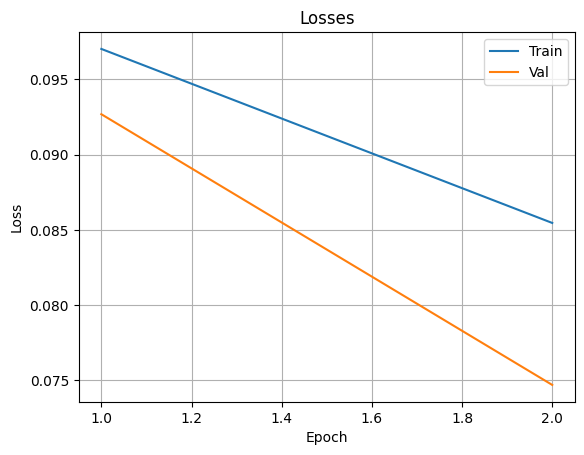

In [61]:
plot_losses(len(train_losses), [train_losses, valid_losses], ["Train", "Val"])
# plt.savefig(losses_img_path)

In [62]:
targets, preds, output_losses  = get_all_predictions(model, test_loader, device, criterion, builder.LABELS)

100%|██████████| 427/427 [00:02<00:00, 165.46it/s]


In [63]:
analyse_predictions(targets, preds)

True values of c1 and their count : 
0.0: 665 occurrences
0.3333333432674408: 625 occurrences
0.6666666865348816: 635 occurrences
1.0: 635 occurrences

Predicted values of c1 and their count: 
0.024857481941580772: 1 occurrences
0.02574942819774151: 1 occurrences
0.027694765478372574: 1 occurrences
0.02807191200554371: 1 occurrences
0.028469741344451904: 1 occurrences
0.02950599044561386: 1 occurrences
0.029863502830266953: 1 occurrences
0.03012342005968094: 1 occurrences
0.030395828187465668: 1 occurrences
0.03137054666876793: 1 occurrences
0.032034024596214294: 1 occurrences
0.03275144472718239: 1 occurrences
0.03373642638325691: 1 occurrences
0.033834975212812424: 1 occurrences
0.0340549573302269: 1 occurrences
0.03425128757953644: 1 occurrences
0.03435558080673218: 1 occurrences
0.03438698872923851: 1 occurrences
0.03451680764555931: 1 occurrences
0.03457404300570488: 1 occurrences
0.034872133284807205: 1 occurrences
0.03493164852261543: 1 occurrences
0.03493194282054901: 1 occurre

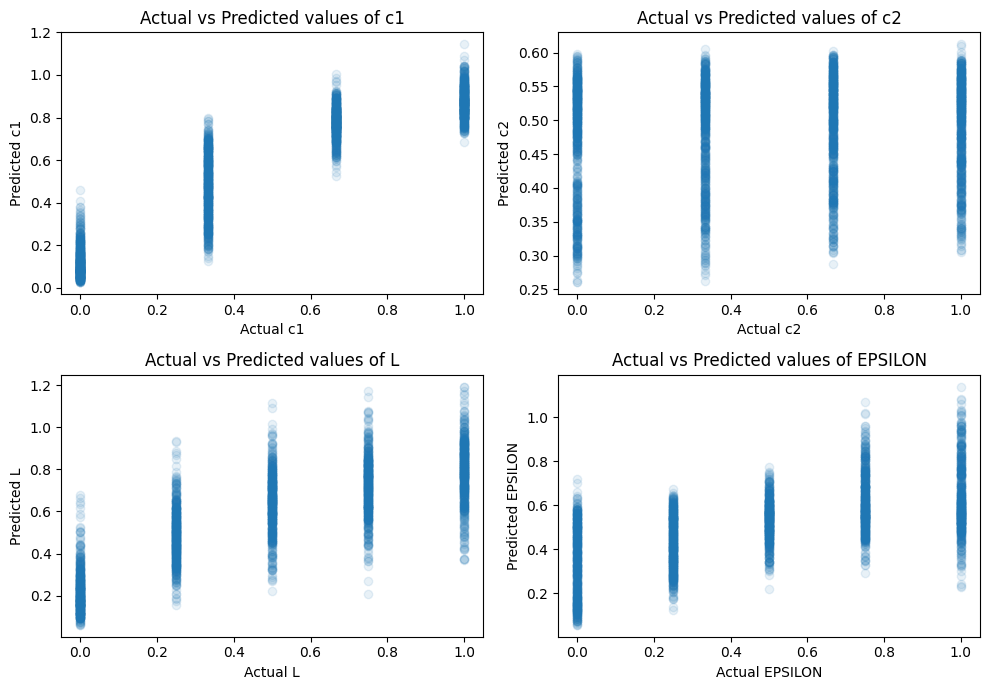

In [64]:
plot_predictions(targets, preds, builder.LABELS)

In [65]:
test_losses = [] 
for target, pred in tqdm(zip(targets, preds)):
    target = torch.FloatTensor(target).to(device=device)
    pred = torch.FloatTensor(pred).to(device=device)
    test_losses.append(criterion(target, pred).item())
test_losses = np.array(test_losses)

699it [00:00, 6981.88it/s]

2560it [00:00, 7692.84it/s]


In [66]:
idx_sort    = np.flip(np.argsort(test_losses))
test_losses = test_losses[idx_sort]
targets     = targets[idx_sort]
preds       = preds[idx_sort]

In [67]:
total_test_loss = np.mean(test_losses)
print("Total Test MSE = {:0.4f}".format(total_test_loss))

Total Test MSE = 0.0734


In [68]:
output_labels = {i: label for i, label in enumerate(builder.LABELS)}
mean_output_losses = {output_labels[i]: np.mean(output_losses[i]) for i in range(len(output_losses))}
print("Test MSE for each output:")
for key, value in mean_output_losses.items():
    print(f"{key}: {value:.4f}")

Test MSE for each output:
c1: 0.0244
c2: 0.1401
L: 0.0506
EPSILON: 0.0785


In [69]:
n_show = 10
print(f"{n_show} Worst Results ==>")
for i in range(n_show):
    print(f"              c1         c2         L         epsilon")
    print(f"Target      = {['{:0.4f}'.format(f) for f in targets[i]]}")
    print(f"Prediction  = {['{:0.4f}'.format(f) for f in preds[i]]}")
    print(f"MSE         = {'{:0.4f}'.format(test_losses[i])}")
    print()

10 Worst Results ==>
              c1         c2         L         epsilon
Target      = ['1.0000', '0.0000', '0.5000', '1.0000']
Prediction  = ['0.9511', '0.5451', '0.9151', '0.3253']
MSE         = 0.2318

              c1         c2         L         epsilon
Target      = ['0.0000', '1.0000', '0.0000', '0.0000']
Prediction  = ['0.0455', '0.3411', '0.6463', '0.2453']
MSE         = 0.2285

              c1         c2         L         epsilon
Target      = ['0.6667', '1.0000', '1.0000', '1.0000']
Prediction  = ['0.8770', '0.4967', '0.9822', '0.2415']
MSE         = 0.2183

              c1         c2         L         epsilon
Target      = ['0.6667', '0.0000', '1.0000', '1.0000']
Prediction  = ['0.8036', '0.4886', '0.9907', '0.2294']
MSE         = 0.2129

              c1         c2         L         epsilon
Target      = ['1.0000', '1.0000', '1.0000', '1.0000']
Prediction  = ['0.8753', '0.5169', '1.1138', '0.2341']
MSE         = 0.2121

              c1         c2         L         eps

In [71]:
n_show = 10
print(f"{n_show} Best Results ==>")
for i in range(n_show, 0, -1):
    print(f"              {[label + '    ' for label in builder.LABELS]}")
    print(f"Target      = {['{:0.4f}'.format(f) for f in targets[-i]]}")
    print(f"Prediction  = {['{:0.4f}'.format(f) for f in preds[-i]]}")
    print(f"WeightedMSE = {'{:0.4f}'.format(test_losses[-i])}")
    print()

10 Best Results ==>
              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['1.0000', '0.6667', '0.7500', '0.5000']
Prediction  = ['0.9198', '0.5836', '0.7646', '0.5755']
WeightedMSE = 0.0048

              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['0.0000', '0.3333', '0.2500', '0.5000']
Prediction  = ['0.0822', '0.3540', '0.3296', '0.5727']
WeightedMSE = 0.0047

              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['0.0000', '0.3333', '0.5000', '0.5000']
Prediction  = ['0.0932', '0.3751', '0.5700', '0.5479']
WeightedMSE = 0.0044

              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['0.0000', '0.3333', '0.7500', '0.5000']
Prediction  = ['0.1091', '0.4015', '0.7287', '0.4861']
WeightedMSE = 0.0043

              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['0.0000', '0.3333', '0.5000', '0.2500']
Prediction  = ['0.0859', '0.3758', '0.5797', '0.2665']
WeightedMSE = 0.0040

              ['c1    ', 